# Spooky Author Identification (NLP)
https://www.kaggle.com/competitions/spooky-author-identification

Getting started tutorial: https://www.kaggle.com/code/rtatman/beginner-s-tutorial-python
The main goal is to use machine learning to predict the author of excerpts from horror stories by Edgar Allan Poe, Mary Shelley, and HP Lovecraft.

## Dataset

The competition dataset contains text from works of fiction written by spooky authors of the public domain: Edgar Allan Poe, HP Lovecraft and Mary Shelley. The data was prepared by chunking larger texts into sentences using CoreNLP's MaxEnt sentence tokenizer, so you may notice the odd non-sentence here and there. Your objective is to accurately identify the author of the sentences in the test set.

### File descriptions
- `train.csv`- the training set
- `test.csv` - the test set
- `sample_submission.csv` - a sample submission file in the correct format

### Data fields
- `id` - a unique identifier for each sentence
- `text` - some text written by one of the authors
- `author` - the author of the sentence (EAP: Edgar Allan Poe, HPL: HP Lovecraft; MWS: Mary Wollstonecraft Shelley)


In [25]:
import nltk
import pandas as pd
import numpy as np

nltk.download('punkt_tab')

import spacy

from multiprocessing import cpu_count
from sklearn.base import TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from spacy import attrs
from spacy.symbols import VERB, NOUN, ADV, ADJ

import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/ellkrauze/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [2]:
# Download data from competition's page
# https://www.kaggle.com/competitions/spooky-author-identification/data
# ! unzip data/train.zip && unzip data/test.zip 

In [3]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

TEXT_COLUMN = 'text'
Y_COLUMN = 'author'

In [4]:
train_df.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [5]:
test_df.head()

,id,text
0,id02310,"Still, as I urged our leaving Ireland with suc..."
1,id24541,"If a fire wanted fanning, it could readily be ..."
2,id00134,And when they had broken down the frail door t...
3,id27757,While I was thinking how I should possibly man...
4,id04081,I am not sure to what limit his knowledge may ...


## 2. EDA

### 2.1. Missing Values

In [13]:
missing_cols = ["id", "text"]

train_df[missing_cols].isnull().sum()

id      0
text    0
dtype: int64

### 2.2. Class Distribution

In [7]:
# EAP: Edgar Allan Poe, HPL: HP Lovecraft; MWS: Mary Wollstonecraft Shelley)
train_df['author'].unique()

array(['EAP', 'HPL', 'MWS'], dtype=object)

<Axes: ylabel='author'>

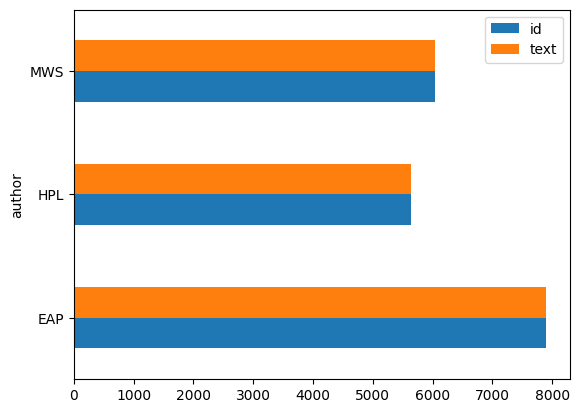

In [12]:
train_df.groupby('author').count().plot(kind='barh')

In [18]:
print(f"Number of unique values in `text` (training): {train_df['text'].nunique()}")

Number of unique values in `text` (training): 19579


### Words Frequency

In [8]:
word_freq_by_author = nltk.probability.ConditionalFreqDist()

for name, group in train_df.groupby("author"):
    author_sentences = group['text'].str.cat(sep = ' ').lower()
    
    author_tokens = nltk.word_tokenize(author_sentences)
    
    frequency = nltk.FreqDist(author_tokens)
    
    word_freq_by_author[name] = frequency


In [9]:
word_freq_by_author.keys()

dict_keys(['EAP', 'HPL', 'MWS'])

As we've observed earlier, the author classes are not balanced. So we should use [StratifiedKFold](https://scikit-learn.org/dev//modules/generated/sklearn.model_selection.StratifiedKFold.html) that helps to generate test sets such that "all contain the same distribution of classes, or as close as possible"

In [30]:
def test_pipeline(df, nlp_pipeline, pipeline_name=''):
    y = df[Y_COLUMN].copy()
    x = pd.Series(df[TEXT_COLUMN])
    
    # If you've done EDA, you may have noticed that the author classes aren't quite balanced.
    # We'll use stratified splits just to be on the safe side.
    skf = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
    
    losses = []
    for train_index, test_index in skf.split(x, y):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        nlp_pipeline.fit(x_train, y_train)
        losses.append(metrics.log_loss(y_test, nlp_pipeline.predict_proba(x_test)))
        
    print(f'{pipeline_name} kfolds log losses: {str([str(round(x, 3)) for x in sorted(losses)])}')
    print(f'{pipeline_name} mean log loss: {round(np.mean(losses), 3)}')

In [20]:
train_df = train_df[[TEXT_COLUMN, Y_COLUMN]]

In [31]:
unigram_pipe = Pipeline(
    # 1. Convert a collection of text documents to a matrix of token counts.
    # 2. Naive Bayes classifier for multinomial models.
    steps=[('cv', CountVectorizer()),('mnb', MultinomialNB())])

test_pipeline(train_df, unigram_pipe, pipeline_name="Unigrams only")

Unigrams only kfolds log losses: ['0.455', '0.46', '0.47', '0.473', '0.474']
Unigrams only mean log loss: 0.466


In [32]:
class UnigramPredictions(TransformerMixin):
    def __init__(self):
        self.unigram_mnb = Pipeline(steps=[('cv', CountVectorizer()), ('mnb', MultinomialNB())])
        
    def fit(self, x, y=None):
        self.unigram_mnb.fit(x, y)
        return self
    
    def add_unigram_predictions(self, text_series):
        df = pd.DataFrame(text_series.reset_index(drop=True))
        unigram_predictions = pd.DataFrame(
            self.unigram_mnb.predict_proba(text_series),
            columns=["naive_bayes_pred_" + x for x in self.unigram_mnb.classes_]
        )
        del unigram_predictions[unigram_predictions.columns[0]]
        df = df.merge(unigram_predictions, left_index=True, right_index=True)
        return df
    
    def transform(self, text_series):
        return self.add_unigram_predictions(text_series)

In [37]:
# ! python -m spacy download en_core_web_sm

NLP = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [43]:
class PartOfSpeechFeatures(TransformerMixin):
    def __init__(self):
        self.NLP = NLP
        self.num_cores = cpu_count()
        
    def part_of_speechiness(self, pos_counts, part_of_speech):
        if eval(part_of_speech) in pos_counts:
            return pos_counts[eval(part_of_speech).numerator]
        return 0
    
    def add_pos_features(self, df):
        text_series = df[TEXT_COLUMN]
        df['doc'] = [i for i in self.NLP.pipe(text_series.values, n_process=self.num_cores)]
        df['pos_counts'] = df['doc'].apply(lambda x: x.count_by(attrs.POS))
        df['sentence_length'] = df['doc'].str.len()
        
        for part_of_speech in ['NOUN', 'VERB', 'ADJ', 'ADV']:
            df[f'{part_of_speech.lower()}iness'] = df['pos_counts'].apply(
                lambda x: self.part_of_speechiness(x, part_of_speech))
            df[f'{part_of_speech.lower()}iness'] /= df['sentence_length']
        
        df['avg_word_length'] = (df['doc'].apply(
            lambda x: sum([len(word) for word in x])) / df['sentence_length'])
        
        return df
    
    def fit(self, x, y=None):
        return self
    
    def transform(self, df):
        return self.add_pos_features(df.copy())

In [44]:
class DropStringColumns(TransformerMixin):
    # You may have noticed something odd about this class: there's no __init__!
    # It's actually inherited from TransformerMixin, so it doesn't need to be declared again.
    def fit(self, x, y=None):
        return self

    def transform(self, df):
        for col, dtype in zip(df.columns, df.dtypes):
            if dtype == object:
                del df[col]
        return df

In [45]:
logit_all_features_pipe = Pipeline([
        ('uni', UnigramPredictions()),
        ('nlp', PartOfSpeechFeatures()),
        ('clean', DropStringColumns()), 
        ('clf', LogisticRegression())])
test_pipeline(train_df, logit_all_features_pipe)

/Users/ellkrauze/projects/ml-playground/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ellkrauze/projects/ml-playground/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.or

 kfolds log losses: ['0.461', '0.464', '0.466', '0.467', '0.473']
 mean log loss: 0.466


In [46]:
def generate_submission_df(trained_prediction_pipeline, df, output_file: str="submission.csv"):
    predictions = pd.DataFrame(
        trained_prediction_pipeline.predict_proba(df.text),
        columns=trained_prediction_pipeline.classes_)
    predictions['id'] = df['id']
    predictions.to_csv(output_file, index=False)
    return predictions

In [47]:
generate_submission_df(logit_all_features_pipe, test_df)

,EAP,HPL,MWS,id
0,0.028442,0.017014,0.954544,id02310
1,0.970564,0.016825,0.012611,id24541
2,0.012810,0.978984,0.008206,id00134
3,0.055290,0.927617,0.017094,id27757
4,0.964880,0.018784,0.016337,id04081
...,...,...,...,...
8387,0.915631,0.028116,0.056253,id11749
8388,0.036512,0.019796,0.943692,id10526
8389,0.971325,0.017546,0.011129,id13477
8390,0.028238,0.017548,0.954214,id13761
